This workbook is a run through of univariate modeling using ARIMA and auto-select ARIMA.
This will cover manually setting the hyperparameters 
Where this workbook will stop, is after using seasonal and non-seasonal ARIMA modeling.

ARIMA stands for AutoRegressive Integrated Moving Average. The model is a combination of the differenced autoregressive mode with the moving average model. 
The AR part shows time series is regressed on its own past data. the I part shows the data values have been replaced with differenced values of d to obtain stationary data. The MA part is the Moving Average part of the model. The benefit of all three combined is that for seasonal models the data prediction can follow the pattern up and down, and not remain at the mean. 
In this way the forecast becomes a combination of the most recent data's effect, the effect of differencing a non-stationary dataset, and the long-term mean value of the series. This also puts more value on the most recent data than further away data. Likewise the further into the future you forecast, the closer the data forecast resembles the mean. 
It should be note that ARMA models also exist, where the data is already stationary and does not require differencing. These would resemble (1,0,1) in the model parameters. 



In [50]:
# Import the necessary libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib 
import scipy 
import sklearn

from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
import seaborn as sns
import statsmodels.api

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5] 


Some functions to use later

In [51]:
# Check Stationarity function

def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [52]:
# split data function, test_split for modelling can be anything between 0 and 1, although usually 0.1, 0.15 or 0.2.

def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [53]:
# for use later. 

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [54]:
#Dataset

life = pd.read_csv('../../../data/USlifeexpenctancyBirth.csv',index_col = 'TIME')
life = life.iloc[0:,5:6]
rename_map = {'Value':'Expectancy'}
life.rename(columns=rename_map, inplace=True)
life.tail(2)

,Expectancy
TIME,
2019,76.3
2020,74.2


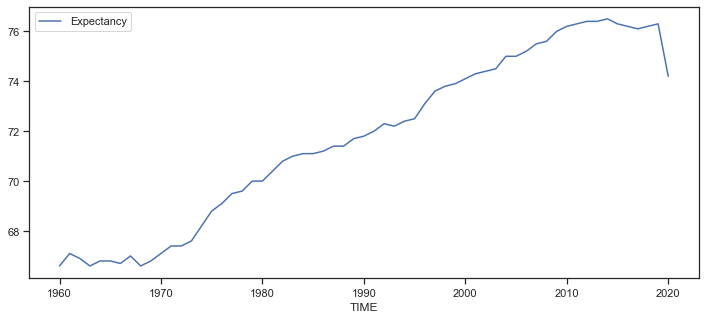

In [55]:
life.plot();
# Here there is a trend evident and the time series will require being made stationary

In [56]:
# splitting the dataset into train and test

test_split = 0.20

life_train, life_test = split_data(life, test_split)

train: 49 , test: 12


In [57]:
#series is non-stationary.
check_stationarity(life)

('Non-Stationary', 0.5267310005814907)

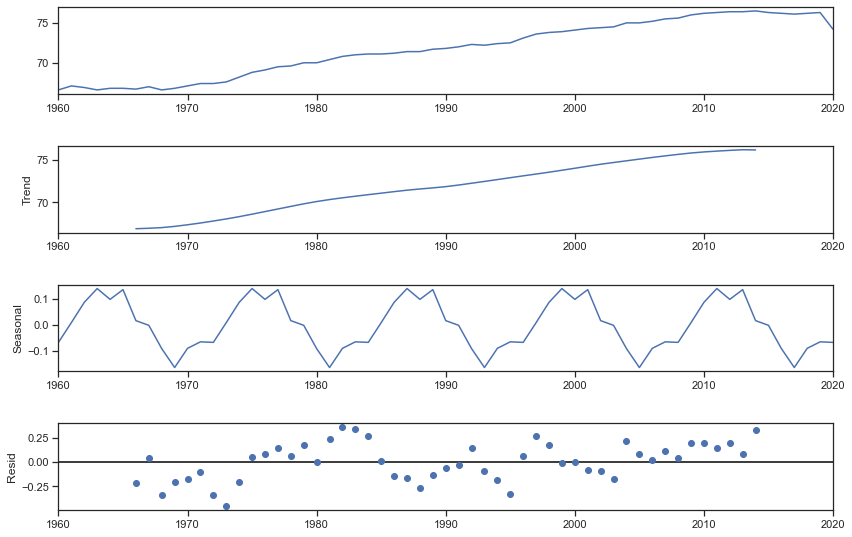

In [58]:
# Seasonal decompose checks the datset for trend and seasonality. No annual seasonality here, but a definite trend. 
sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(life, period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();


There are three parts to the tuning of an ARIMA model, 4 to a SARIMAX. The parameters are (p,d,q).
The first stage with an ARIMA or SARIMAX model is to find the hyperparameter tunings, the p for AR, which is the auto-regressive part of the 'AR'IMA model. This value can be found from the PACF graph, which you run on the differenced univariate series of data. 
The d is the differencing order. The q is the MA part, the moving average which you obtain from the ACF graph. 
Below we will plot the ACF and PACF graphs to show you how to obtain these numbers.

In [59]:
#check stationarity of the life differenced dataset. Now this is < 0.05 can say data is now stationary.
life_diff = life.Expectancy.diff().dropna()
check_stationarity(life_diff)

'Stationary	 p-value:0.005698319652473299 	 lags:0


('Stationary', 0.005698319652473299)

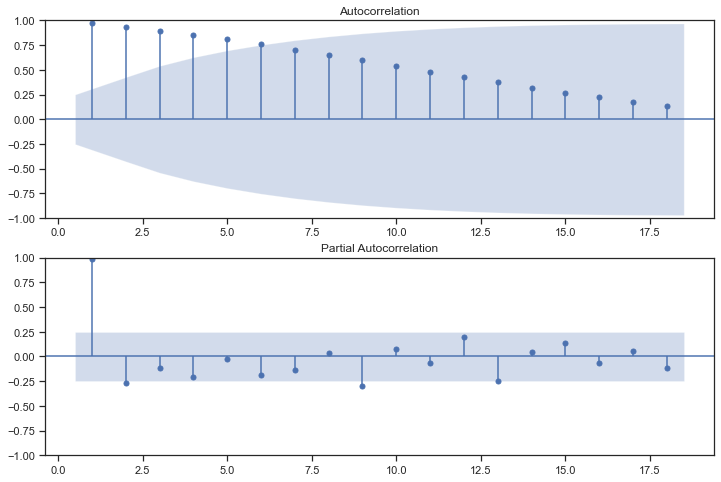

In [60]:
# Examining the autocorrelation plot. There is autocorrelation both in the Acf and PACF charts. 
# This shows that there will be values for p and for q in the modelling. 
# The PACF chart gives a p value for (p,d,q). Here it suggests strong significance at 1, and potentially some significance at 2. 
# The ACF chart gives strong significance indications up until point 5, potentially 6. 
# but these charts are run on the undifferenced data. Lets re-run them again on the differenced dataset.

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life.Expectancy, zero=False, ax=ax[0])
plot_pacf(life.Expectancy, zero=False, ax=ax[1])
plt.show() 

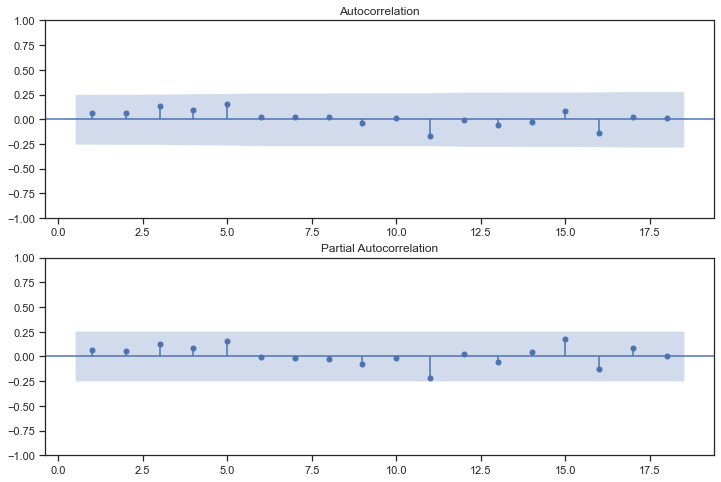

In [61]:
# Running ACF and PACF on the differenced datasets. 
# Here we're struggling to see any autocorrelation or partial autocorrelation. 
# There are further tools we can use to examine what p, d and q should be used for this dataset.

fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show() 

In tuning the ARIMA model for the best fit with the dataset, there are metrics to measure the best fit model. 
AIC is one, 'Akaike Information Criterion'. https://www.sciencedirect.com/topics/pharmacology-toxicology-and-pharmaceutical-science/akaike-information-criterion
What is this. This is a metric that looks at the sample variance and produces a lower score the lower the model variance. 
Ideally you're looking for a model that produces a low AIC, for variance, and a low BIC (Bayesian Information Criterion), which indicates a lower penalty for the model. 


(1, 3)


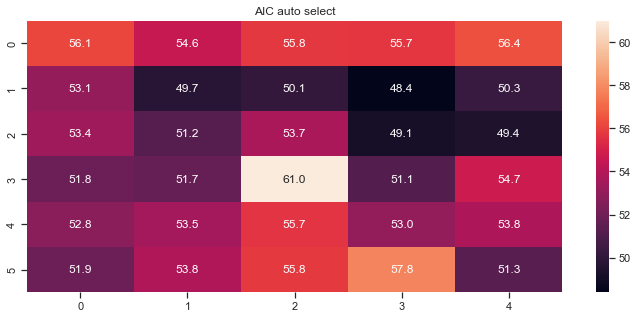

In [62]:
# Auto-select function to identify the p, and q for ARIMA.

# From the results, (1,3) appear to be the optimal p and q for the AIC criterion. 

auto_select = sm.tsa.stattools.arma_order_select_ic(life_diff, max_ar=5, max_ma=4, ic='aic', trend='n', model_kw={}, fit_kw={})

print(auto_select.aic_min_order)

sns.heatmap(auto_select['aic'], annot=True, fmt='.1f')
plt.ylim([auto_select['aic'].shape[0], 0])
plt.title('AIC auto select')
plt.show()

In [63]:
# best p and q are 1 and 3. lowest score of 48.4

from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(life['Expectancy'],order = (1,1,3)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Expectancy   No. Observations:                   61
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 -19.197
Date:                Thu, 29 Sep 2022   AIC                             48.393
Time:                        16:47:26   BIC                             58.865
Sample:                             0   HQIC                            52.490
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8942      0.150      5.977      0.000       0.601       1.187
ma.L1         -0.9318      0.281     -3.313      0.001      -1.483      -0.381
ma.L2         -0.0840      0.413     -0.203      0.839      -0.893       0.725
ma.L3          0.4393      0.277      1.587      0.112      -0.103       0.982
sigma2         0.1077      0.021      5.132      0.000       0.067       0.149
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               658.88
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                            -2.97
Prob(H) (two-sided):                  0.03   Kurtosis:                        18.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
life_tdiff = life_train.diff().dropna()


0 0 0.1467846875613826
0 1 0.14624419108070416
0 2 0.1475038250910923
0 3 0.14979040043943695
0 4 nan
1 0 0.14627453192164672
1 1 0.14698037213923532
1 2 0.14925723196125992
1 3 0.15000440313375948
1 4 nan
2 0 0.14815051859448133
2 1 0.14774878108870135
2 2 0.1524960222900464
2 3 0.16105968409033888
2 4 nan
3 0 0.14574389480943972
3 1 0.1457555580442185
3 2 0.16288629619554362
3 3 0.15527574013352777
3 4 nan
4 0 0.14595212118523093
4 1 0.14608674977774122
4 2 0.14712369350128687
4 3 0.14812357048841204
4 4 nan
(3, 0) 0.14574389480943972


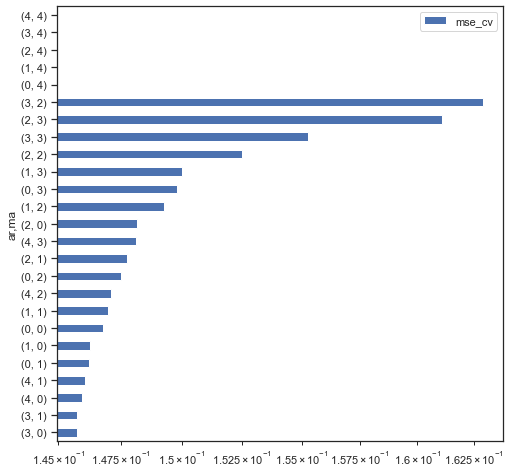

In [68]:
# Another way to check the best model output 
from sklearn.model_selection import TimeSeriesSplit

ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(life['Expectancy'].diff().values)]

best_order = (0, 0)
best_mse = 10**10
scores = []

for ar_order in range(5):
    for ma_order in range(5):
        try:
            mses = []
            for i in range(ts.n_splits):
                y_train = life['Expectancy'].diff().values[splits[i][0]]
                y_test = life['Expectancy'].diff().values[splits[i][1]]

                model_cv = ARIMA(y_train, order=(ar_order, 0, ma_order))
           
                result_cv = model_cv.fit()
                #start_params=np.zeros(model_cv.k_ar+model_cv.k_ma),
                 #              solver='lbfgs', method='css', trend='nc', ic='BIC')
                predictions_test = result_cv.predict(start=len(y_train), end=len(y_train)+len(y_test)-1)
                mses.append(((y_test - (predictions_test))**2).mean())
               
            mse_mean = np.mean(mses)
            scores.append((model_cv.k_ar, model_cv.k_ma, mse_mean))
            print(model_cv.k_ar, model_cv.k_ma, mse_mean)
            if mse_mean < best_mse:
                best_mse = mse_mean
                best_order = (model_cv.k_ar, model_cv.k_ma)

        except:
                scores.append((model_cv.k_ar, model_cv.k_ma, np.nan))
                print(model_cv.k_ar, model_cv.k_ma, np.nan)
               
print(best_order, best_mse)

df_r = pd.DataFrame(scores, columns=['ar', 'ma', 'mse_cv'])
df_r.groupby(['ar', 'ma'])[['mse_cv']].max().sort_values(by='mse_cv').plot(kind='barh', figsize=(8, 8))
plt.xscale('log')
plt.show()

In [69]:
# this parameter check suggests p = 3 and q = 0 for a best_mse fit
model2 = ARIMA(life['Expectancy'], order = (3,1,0)).fit()


In [74]:
# Summary statistics function show the results of the model2 run.

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Expectancy   No. Observations:                   61
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 -21.924
Date:                Thu, 29 Sep 2022   AIC                             51.848
Time:                        17:11:51   BIC                             60.225
Sample:                             0   HQIC                            55.125
                                 - 61                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1317      0.264      0.499      0.618      -0.386       0.649
ar.L2          0.1433      0.340      0.422      0.673      -0.523       0.810
ar.L3          0.3878      0.327      1.186      0.236      -0.253       1.029
sigma2         0.1202      0.009     13.286      0.000       0.102       0.138
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              1165.75
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -3.60
Prob(H) (two-sided):                  0.01   Kurtosis:                        23.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

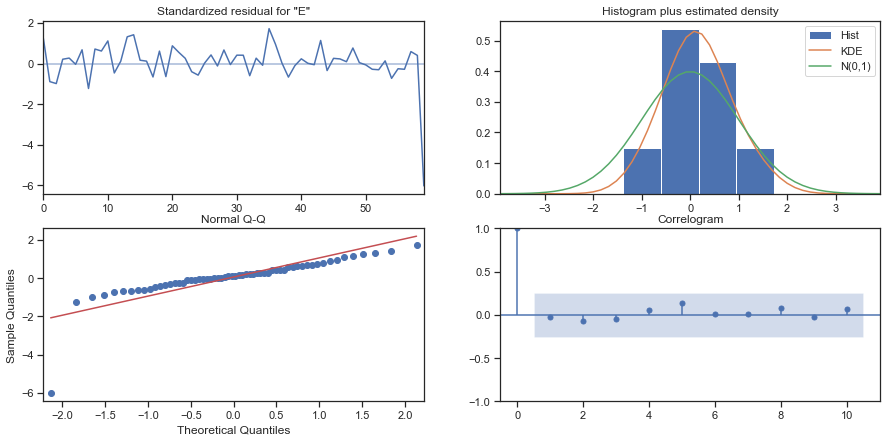

In [72]:
model2.plot_diagnostics(figsize=(15,7));plt.show();

predicted=75.653001, expected=75.600000
predicted=75.750550, expected=76.000000
predicted=76.186921, expected=76.200000
predicted=76.372589, expected=76.300000
predicted=76.494681, expected=76.400000
predicted=76.574998, expected=76.400000
predicted=76.533083, expected=76.500000
predicted=76.609117, expected=76.300000
predicted=76.334496, expected=76.200000
predicted=76.202480, expected=76.100000
predicted=76.037862, expected=76.200000
predicted=76.154220, expected=76.300000
predicted=76.277659, expected=74.200000
Test RMSE: 0.595


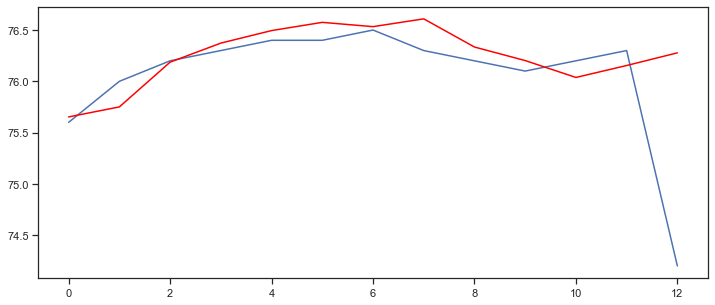

In [75]:
# forecasting forward. 

from sklearn.metrics import mean_squared_error
from math import sqrt
X = life['Expectancy'].values

# split data into train and test.
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# using the best order found previously.
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()